# Redes neuronales para clasificación de secuencias

Ahora veremos cómo podemos, a partir de una secuencia de datos, inferir a qué clase pertenecen. Para esta tarea vamos a usar nuevamente un RNN del tipo LSTM, pero esta vez con una sola salida.

La tarea que vamos a tener es la siguiente: a partir de menus que proporcionan los restaurantes, clasificar estos restaurantes en una categoría de precios. Vamos a tener cuatro categorías de prcios, donde 1 son los restaurantes más baratos, mientras que 4 son los más caros. 

## Cargar las bibliotecas necesarias

In [3]:
import json

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Activation, SpatialDropout1D, Input
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Preparar los datos

Como hemos visto en el ejercicio pasado, debemos cargar los datos. Además será necesario ver cómo su organización 

In [4]:
train_set = list()
dev_set = list()

with open("../data/trainset.json") as F:
    for line in F:
        train_set.append(json.loads(line))
with open("../data/devset.json") as F:
    for line in F:
        dev_set.append(json.loads(line))

print(train_set[1])
print(len(train_set))
print(len(dev_set))

{'rating': '$$', 'name': 'Bin38', 'type': 'american (new)', 'location': 'sf', 'menu': ['bin frittata artisan ham swiss cheese potatoes mixed greens', 'sweet corn fritters wildflower honey whipped butter', 'strawberry eclairs white chocolate mousse hazelnuts', 'grilled cheese on whole wheat fontina smoked mozzarella oven roasted tomatoes arugula basil mayo', 'beef brisket panini fontina oven roasted tomatoes arugula horseradish sauce items marked with served before pm', 'hot beef brisket sandwich creamy horseradish sauce slaw french fries', 'roasted wild mushroom panini fromage blanc gypsy peppers creamy smoked pepper dip', 'house made chicken sausage grilled summer squash basil pesto', 'bacon wrapped sea scallops summer melon herb salad balsamic', 'american artisan cheeses small house made crackers fruit and condiments items marked with served before pm', 'warm marinated olives items marked with served before pm', 'wild mushroom gypsy pepper panini fromage blanc creamy smoked pepper di

In [5]:
train_ratings = list()
train_menus = list()

dev_ratings = list()
dev_menus = list()

dictionary = list()
rating_labels = list()

for restaurant in train_set:
    menu = " . ".join(restaurant["menu"]).split()
    train_menus.append(menu)
    train_ratings.append(len(restaurant["rating"])-1)
    dictionary += menu

for restaurant in dev_set:
    menu = " . ".join(restaurant["menu"]).split()
    dev_menus.append(menu)
    dev_ratings.append(len(restaurant["rating"])-1)

dictionary = list(set(dictionary))
print(train_menus[0][:30])
print(train_ratings[0])
print(len(dictionary))


['squid', 'tofu', 'lunch', 'cooked', 'squid', 'tofu', 'vegetables', 'with', 'seasoned', 'soy', 'sauce', '.', 'edamame', 'broiled', 'green', 'soybeans', '.', 'hotate', 'scallop', '.', 'oyako', 'don', 'dinner', 'chicken', 'vegetables', 'and', 'egg', 'cooked', 'with', 'sweet']
1
44090


Ahora nuevamente convertiremos todas las palabras en enteros y los rankings a varables categóricas

In [6]:
word_to_index = {"PAD":0,"OOV":1, "BOS":2, "EOS":3}
for word in dictionary:
    word_to_index[word] = len(word_to_index)

def sent_to_int(sent):
    int_sent = list()
    for word in sent:
        if word in word_to_index.keys():
            int_sent.append(word_to_index[word])
        else:
            int_sent.append(word_to_index["OOV"])
    return int_sent

train_X, dev_X, train_Y, dev_Y = list(), list(), list(), list()

for lineX, lineY in zip(train_menus, train_ratings):
    train_X.append(sent_to_int(lineX))
    train_Y.append(to_categorical(lineY, num_classes=4))

for lineX, lineY in zip(dev_menus, dev_ratings):
    dev_X.append(sent_to_int(lineX))
    dev_Y.append(to_categorical(lineY, num_classes=4))
    
train_Y = np.asarray(train_Y)
dev_Y = np.asarray(dev_Y)

print(train_X[1])
print(train_Y[1])

[34575, 25576, 35563, 42917, 35973, 40290, 26141, 3375, 9834, 23385, 3787, 42617, 21955, 13541, 26337, 42158, 13569, 23385, 10563, 4874, 31501, 1662, 29253, 34188, 23385, 10008, 40290, 35584, 18122, 19892, 43423, 30179, 37662, 32648, 10552, 31229, 18511, 29724, 32769, 23385, 8027, 13330, 27483, 43423, 32648, 10552, 31229, 18511, 37187, 36091, 3714, 11431, 3730, 8021, 29591, 21714, 23385, 3644, 8027, 13330, 41082, 3088, 37187, 36091, 43364, 23051, 12810, 23385, 10552, 4215, 25978, 27483, 15520, 25667, 38426, 12113, 3088, 30179, 17485, 19327, 23385, 692, 35298, 23434, 40832, 10008, 34166, 15346, 29724, 4881, 23385, 31630, 24640, 32124, 3690, 34166, 21641, 32544, 24801, 5566, 23385, 20379, 35563, 14478, 9788, 692, 35298, 43542, 11324, 6815, 19181, 3714, 11431, 3730, 8021, 29591, 21714, 23385, 17434, 39405, 34487, 3714, 11431, 3730, 8021, 29591, 21714, 23385, 4215, 25978, 38426, 17485, 27483, 15520, 25667, 3088, 30179, 17485, 19327, 3714, 11431, 3730, 8021, 29591, 21714, 23385, 10008, 3416

Limitaremos el tamaño de las entradas a 200 palabras, dada la gran variabilidad de los menus encontrados.

In [7]:
MAX_LENGTH = 300
train_X = pad_sequences(maxlen=MAX_LENGTH, sequences=train_X, padding="post")
dev_X = pad_sequences(maxlen=MAX_LENGTH, sequences=dev_X, padding="post")

print(train_X[1])


[29724  4881 23385 31630 24640 32124  3690 34166 21641 32544 24801  5566
 23385 20379 35563 14478  9788   692 35298 43542 11324  6815 19181  3714
 11431  3730  8021 29591 21714 23385 17434 39405 34487  3714 11431  3730
  8021 29591 21714 23385  4215 25978 38426 17485 27483 15520 25667  3088
 30179 17485 19327  3714 11431  3730  8021 29591 21714 23385 10008 34166
 15346  1715 40290 29724  4881 23763 23385 13140 35902 42654 23559 10579
 23385 17743  8418 10552 33486 35973 27483 18122  4097  8449 18460 23385
   692 35298 39731 40832 32451 13707 24801 18122  4097  8449 23385 10679
 33486  7183 14526 34013   982 40857 36091 23385 17709 31229 43101  1715
 40290 18511 14957 24014 23131 23385 34575  3375 19278  3714 11431  3730
  8021 29591 21714 23385 40118 12097 24801  4536 39956 15858 16073 13405
 36256 25667 23131  3714 11431  3730  8021 29591 21714 23385 20379 35563
 14478 35593   692 35298 43542 11324  6815 19181  3714 11431  3730  8021
 29591 21714 23385 13146 29704  1662 36286 42158 29

## Definir el modelo y entrenar con LSTM

Ahora definimos nuestra red. Veamamos ahora que configuraremos algunos hyperparámetros adicionales en el optimizador, ademas de usar Adam esta vez.

In [13]:
EMBEDDING_SIZE = 50
EPOCHS = 10
BATCH_SIZE = 32
HIDDEN_LAYER_SIZE = 200
DROPOUT = 0.2

input = Input(shape=(MAX_LENGTH,))
model = Embedding(len(word_to_index), EMBEDDING_SIZE, input_length=MAX_LENGTH)(input)
model = SpatialDropout1D(DROPOUT)(model)
model = LSTM(HIDDEN_LAYER_SIZE, dropout=DROPOUT, recurrent_dropout=DROPOUT)(model)
model = Dense(4)(model)
out = Activation("sigmoid")(model)

model = Model(input, out)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy",])

Y la entrenamos. Dado que el entrenamiento será largo, vamos a utilizar una opción llamada parada temprana o early stopping. Básicamente lo que hace es parar el entrenamiento cuando no se logre mejorar el costo en un cierto periodo de épocas. Ese periodo de épocas es llamado paciencia (patience).

In [14]:
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=3)
model_save = ModelCheckpoint('best_classification.hdf5', save_best_only=True, monitor='val_accuracy', mode='min')

history = model.fit(train_X, train_Y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(dev_X, dev_Y), callbacks=[es, model_save])

Train on 4860 samples, validate on 607 samples
Epoch 1/10
 160/4860 [..............................] - ETA: 1:34 - loss: 1.3744 - accuracy: 0.4812

KeyboardInterrupt: 

## Resultados

Ahora veamos el comportamiento del entrenamiento a travéz de las épocas.

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')


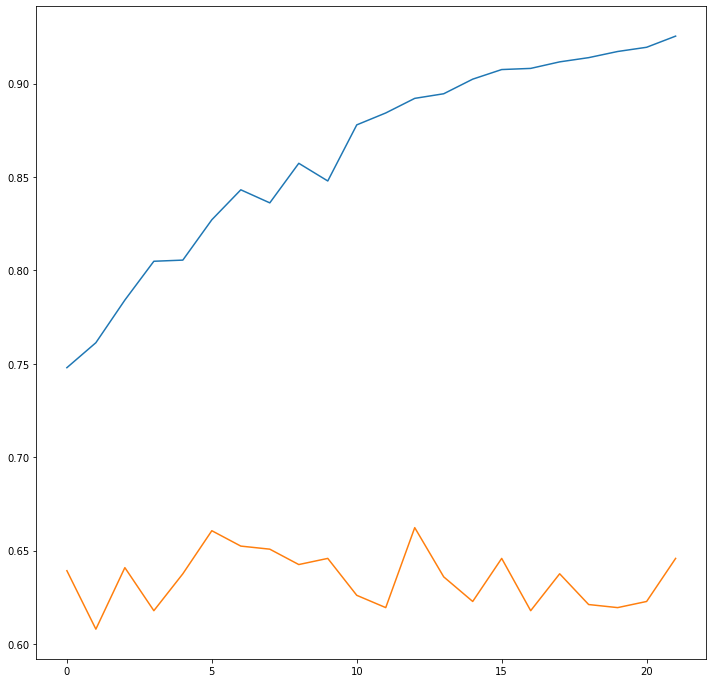

In [28]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
print(hist.keys())
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

Y guardamos el modelo

In [ ]:
model.save("Models/restaurant_classification.h5")

## Ejercicio

Hemos visto cómo usar un LSTM para entrenar un modelo que nos permite clasificar un texto. Sin embargo, el set de datos con el que contamos incluye información complementaria: cómo tipo de restaurante y localización del mismo. Es hora de integrar estos datos para mejorar el rendimiento del modelo. 

* ¿Cuál sería la mejor forma de integrar estos datos al modelo?
* Implemente una solución y demuestre que su modelo mejora al LSTM simple.
* ¿Tiene alguna otra idea de cómo mejorar el rendimiento del modelo?